# Web Scraping and Linear Regression with Car Data

Purpose: web scrape used car data and estimate pricing based on car attributes like age, mileage, color, and model type

In [1]:
# bs4=BeautifulSoup for parsing the HTML text returned from a URL
# requests gets our HTML text

import bs4
import requests
import pandas as pd
from datetime import datetime

# Scraping a single URL

Note: 
* 05/29/20: These links may rot as cars get sold. Go to CarFax.com, apply a few search filters, and click on several cars of interest.
* In this example, we use the Honda Civic for year 2017 or higher

In [2]:
# the soup object contains the full HTML text and car attributes
url = 'https://www.carfax.com/vehicle/19XFC2F57JE025910'
resp = requests.get(url)
soup = bs4.BeautifulSoup(resp.text)
print(soup)

<!DOCTYPE html>
<html>
<head>
<title data-react-helmet="true">19XFC2F57JE025910 | 2018 Honda Civic LX for sale in Elgin, IL </title>
<link href="https://media.carfax.com" rel="dns-prefetch"/>
<link href="https://static.carfax.com" rel="dns-prefetch"/>
<link crossorigin="true" href="https://carfax-img.vast.com" rel="preconnect"/>
<link href="/manifest.json" rel="manifest"/>
<link href="https://static.carfax.com/uclassets/images/favicon-228.png" rel="apple-touch-icon"/>
<link href="https://static.carfax.com/uclassets/images/favicon-228.png" rel="apple-touch-startup-image"/>
<meta content="#3777bc" name="theme-color"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta charset="utf-8"/>
<script type="text/javascript">window.NREUM||(NREUM={});NREUM.info = {"agent":"","beacon":"bam.nr-data.net","errorBeacon":"bam.nr-data.net","licenseKey":"c882024f46","applicationID":"53224171","applicationTime":136.840458,"transactionName":"M1EBYkcEDEpQBk1QDQobJk5FFwdKQg9KFiUhYEwZ","queueTime":0,

In [3]:
# use soup selecters to narrow down to HTML containing data 
soup.select('.vehicle-info-details')

[<div class="vehicle-info-details vehicle-info-details-title">Price </div>,
 <div class="vehicle-info-details-price vehicle-info-details">$15,340</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Mileage </div>,
 <div class="vehicle-info-details">6,516 miles </div>,
 <div class="vehicle-info-details vehicle-info-details-title">Location </div>,
 <div class="vehicle-info-details">Elgin, IL </div>,
 <div class="vehicle-info-details vehicle-info-details-title">Exterior Color </div>,
 <div class="vehicle-info-details">Black</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Interior Color </div>,
 <div class="vehicle-info-details">Black</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Drive Type </div>,
 <div class="vehicle-info-details">FWD</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Transmission </div>,
 <div class="vehicle-info-details">Automatic</div>,
 <div class="vehicle-info-details vehicle-info-details

In [4]:
# parse data points of interest

# multiple assignment trick
    # the '*_' assigns an arbitrary number of elements that we don't care about to '_'
    # idiom for throw-away variables that we don't use is the '_' single underscore character 

# price, mileage, etc are 'tag' elements
_, price, _, mileage, _, loc, _, color_ext, *_ = soup.select('.vehicle-info-details')
price, mileage, loc, color_ext

(<div class="vehicle-info-details-price vehicle-info-details">$15,340</div>,
 <div class="vehicle-info-details">6,516 miles </div>,
 <div class="vehicle-info-details">Elgin, IL </div>,
 <div class="vehicle-info-details">Black</div>)

In [5]:
# get text from from tag elements via tag.getText() and store in dictionary format

columns=['price', 'mileage', 'loc', 'color_ext']
data_vals = [xtag.getText() for xtag in [price, mileage, loc, color_ext]]
data = zip(columns, data_vals)
data = dict(data)
data

{'price': '$15,340',
 'mileage': '6,516 miles ',
 'loc': 'Elgin, IL ',
 'color_ext': 'Black'}

In [6]:
# convert dictionary to dataframe

df = pd.DataFrame.from_dict(data, orient='index').T
df['url'] = url
df

,price,mileage,loc,color_ext,url
0,"$15,340","6,516 miles","Elgin, IL",Black,https://www.carfax.com/vehicle/19XFC2F57JE025910


# Make this a function, loop through a list of URLs, and consolidate

In [7]:
def url_to_df(url):
    '''Parse data from carfax url

    Example
    -------
    >>> url = 'https://www.carfax.com/vehicle/SHHFK7H48JU208178'
    >>> df = parse_url(url)
    '''
    resp = requests.get(url)
    soup = bs4.BeautifulSoup(resp.text)
    _, price, _, mileage, _, loc, _, color_ext, *_ = soup.select('.vehicle-info-details')
    columns=['price', 'mileage', 'loc', 'color_ext']
    data_vals = [x.getText() for x in [price, mileage, loc, color_ext]]
    data = zip(columns, data_vals)
    data = dict(data)
    df = pd.DataFrame.from_dict(data, orient='index').T
    df['mileage'] = df['mileage'].str.replace(' miles', '')
    df['url'] = url
    df['label'] = soup.select('.vehicle-title')[0].getText()
    df['year'] = df['label'].str.slice(0,4)
    df = df[['label', 'year', 'mileage', 'price', 'color_ext', 'loc', 'url']]
    return df


In [8]:
urls = ['https://www.carfax.com/vehicle/2HGFC2F6XKH516438',
 'https://www.carfax.com/vehicle/19XFB2F52FE095230',
 'https://www.carfax.com/vehicle/SHHFK7H57JU237048',
 'https://www.carfax.com/vehicle/SHHFK7H54JU209689',
 'https://www.carfax.com/vehicle/19XFB2F71FE024814',
 'https://www.carfax.com/vehicle/2HGFC3A56KH750872',
 'https://www.carfax.com/vehicle/19XFC1F31HE017014',
 'https://www.carfax.com/vehicle/2HGFC3B70HH361556',
 'https://www.carfax.com/vehicle/2HGFC4B60KH304679',
 'https://www.carfax.com/vehicle/SHHFK7H42HU211538',
 'https://www.carfax.com/vehicle/SHHFK7H56HU232918',
 'https://www.carfax.com/vehicle/19XFA1F50BE030688',
 'https://www.carfax.com/vehicle/2HGFC3B39JH352003',
 'https://www.carfax.com/vehicle/19XFC2F57JE025910',
 'https://www.carfax.com/vehicle/2HGFC4B50GH301957',
 'https://www.carfax.com/vehicle/2HGFC3B72JH351813',
 'https://www.carfax.com/vehicle/19XFB2F50FE059830',
 'https://www.carfax.com/vehicle/19XFB2F50FE059830',
 'https://www.carfax.com/vehicle/19XFC2F59JE007764',
 'https://www.carfax.com/vehicle/19XFB2F56FE114488',
 'https://www.carfax.com/vehicle/19XFC2F50HE075008',
 'https://www.carfax.com/vehicle/2HGFC3B32GH351929',
 'https://www.carfax.com/vehicle/2HGFC3B34HH355773',
 'https://www.carfax.com/vehicle/2HGFC2F71HH525403',
 'https://www.carfax.com/vehicle/19XFC2F5XHE034790']

In [9]:
# initialize empty dataframe and concatenate new sub dataframes with itself
df_all = pd.DataFrame()
for url in urls:
    print(url)
    df_sub = url_to_df(url)
    df_all = pd.concat([df_all, df_sub])

df_all = df_all.reset_index(drop=True)

# convert price string to integer 
df_all['price'] = df_all['price'].str.replace('$','').str.replace(',','').astype(int)

https://www.carfax.com/vehicle/2HGFC2F6XKH516438
https://www.carfax.com/vehicle/19XFB2F52FE095230
https://www.carfax.com/vehicle/SHHFK7H57JU237048
https://www.carfax.com/vehicle/SHHFK7H54JU209689
https://www.carfax.com/vehicle/19XFB2F71FE024814
https://www.carfax.com/vehicle/2HGFC3A56KH750872
https://www.carfax.com/vehicle/19XFC1F31HE017014
https://www.carfax.com/vehicle/2HGFC3B70HH361556
https://www.carfax.com/vehicle/2HGFC4B60KH304679
https://www.carfax.com/vehicle/SHHFK7H42HU211538
https://www.carfax.com/vehicle/SHHFK7H56HU232918
https://www.carfax.com/vehicle/19XFA1F50BE030688
https://www.carfax.com/vehicle/2HGFC3B39JH352003
https://www.carfax.com/vehicle/19XFC2F57JE025910
https://www.carfax.com/vehicle/2HGFC4B50GH301957
https://www.carfax.com/vehicle/2HGFC3B72JH351813
https://www.carfax.com/vehicle/19XFB2F50FE059830
https://www.carfax.com/vehicle/19XFB2F50FE059830
https://www.carfax.com/vehicle/19XFC2F59JE007764
https://www.carfax.com/vehicle/19XFB2F56FE114488
https://www.carfax.c

In [10]:
df_all

,label,year,mileage,price,color_ext,loc,url
0,2019 Honda Civic LX,2019,"9,082",16499,Gray,"Crystal Lake, IL",https://www.carfax.com/vehicle/2HGFC2F6XKH516438
1,2015 Honda Civic LX,2015,"89,895",8995,Black,"Addison, IL",https://www.carfax.com/vehicle/19XFB2F52FE095230
2,2018 Honda Civic EX,2018,"17,194",19330,Silver,"Gurnee, IL",https://www.carfax.com/vehicle/SHHFK7H57JU237048
3,2018 Honda Civic EX,2018,"23,027",18900,Black,"Joliet, IL",https://www.carfax.com/vehicle/SHHFK7H54JU209689
4,2015 Honda Civic SE,2015,"75,326",9995,White,"Addison, IL",https://www.carfax.com/vehicle/19XFB2F71FE024814
5,2019 Honda Civic Si,2019,"16,788",21000,Blue,"Joliet, IL",https://www.carfax.com/vehicle/2HGFC3A56KH750872
6,2017 Honda Civic EX-T,2017,"22,019",16999,Blue,"Crystal Lake, IL",https://www.carfax.com/vehicle/19XFC1F31HE017014
7,2017 Honda Civic EXL,2017,"24,137",17000,Black,"Joliet, IL",https://www.carfax.com/vehicle/2HGFC3B70HH361556
8,2019 Honda Civic LX,2019,"5,383",16990,Blue,"Elmhurst, IL",https://www.carfax.com/vehicle/2HGFC4B60KH304679
9,2017 Honda Civic Sport,2017,"62,360",15500,Silver,"Elgin, IL",https://www.carfax.com/vehicle/SHHFK7H42HU211538


# Predictive model using ordinary least squares regression (OLS)

### Primer
* Relationship between dependent variable (value we want to predict)
* Constant/intercept
* Slope coefficient
* Random error term

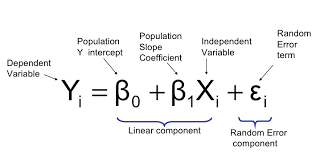

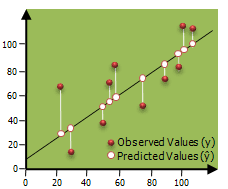

![image.png](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR-tWrEwqgBkxDc2KOkS-RvsLd6b4XTUdQ9LsdWrhS65UCGY8I7&usqp=CAU)

### Prepare model inputs
* note that we omit 1 of the model dummy variables
* use n-1 dummy variables where n=number of unique categories
* reference
    * https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables

In [11]:
# y is independent variable to predict that depends on X's
# convention is capital X for predictor variables

y = df_all['price']
X = pd.DataFrame(index=df_all.index)

# format X variables 
X['age'] = datetime.today().year - df_all['year'].astype(int)
X['mileage'] = df_all['mileage'].str.replace(',','').astype(int)
# X['dummy_lx'] = df_all['label'].str.lower().str.contains('lx').astype(int)
X['dummy_ex'] = df_all['label'].str.lower().str.contains('ex').astype(int)
X['dummy_si'] = df_all['label'].str.lower().str.contains('si').astype(int)
X['dummy_sport'] = df_all['label'].str.lower().str.contains('sport').astype(int)

In [12]:
X.head(10)

,age,mileage,dummy_ex,dummy_si,dummy_sport
0,1,9082,0,0,0
1,5,89895,0,0,0
2,2,17194,1,0,0
3,2,23027,1,0,0
4,5,75326,0,0,0
5,1,16788,0,1,0
6,3,22019,1,0,0
7,3,24137,1,0,0
8,1,5383,0,0,0
9,3,62360,0,0,1


In [13]:
# merge to view prepared variables with original dataframe
merged = df_all.merge(X, left_index=True, right_index=True)
merged.head(10).drop(columns='url')

,label,year,mileage_x,price,color_ext,loc,age,mileage_y,dummy_ex,dummy_si,dummy_sport
0,2019 Honda Civic LX,2019,"9,082",16499,Gray,"Crystal Lake, IL",1,9082,0,0,0
1,2015 Honda Civic LX,2015,"89,895",8995,Black,"Addison, IL",5,89895,0,0,0
2,2018 Honda Civic EX,2018,"17,194",19330,Silver,"Gurnee, IL",2,17194,1,0,0
3,2018 Honda Civic EX,2018,"23,027",18900,Black,"Joliet, IL",2,23027,1,0,0
4,2015 Honda Civic SE,2015,"75,326",9995,White,"Addison, IL",5,75326,0,0,0
5,2019 Honda Civic Si,2019,"16,788",21000,Blue,"Joliet, IL",1,16788,0,1,0
6,2017 Honda Civic EX-T,2017,"22,019",16999,Blue,"Crystal Lake, IL",3,22019,1,0,0
7,2017 Honda Civic EXL,2017,"24,137",17000,Black,"Joliet, IL",3,24137,1,0,0
8,2019 Honda Civic LX,2019,"5,383",16990,Blue,"Elmhurst, IL",1,5383,0,0,0
9,2017 Honda Civic Sport,2017,"62,360",15500,Silver,"Elgin, IL",3,62360,0,0,1


In [14]:
X.describe()

,age,mileage,dummy_ex,dummy_si,dummy_sport
count,25.000000,25.000000,25.0,25.00,25.00
mean,3.240000,36346.440000,0.4,0.04,0.04
std,1.762574,28155.383791,0.5,0.20,0.20
min,1.000000,5383.000000,0.0,0.00,0.00
25%,2.000000,20149.000000,0.0,0.00,0.00
50%,3.000000,26189.000000,0.0,0.00,0.00
75%,4.000000,37750.000000,1.0,0.00,0.00
max,9.000000,104879.000000,1.0,1.00,1.00


### Fit the model and inspect result parameters

In [15]:
# for more documentation on Ordinary Least Squares with statsmodels, see:
    # https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
    # you can also check out scikit-learn which has a similar API pattern
    # "model" object that takes array-like objects

import statsmodels.api as sm

# Our model needs an intercept so we add a column of 1s
X = sm.add_constant(X)

# ex: for binary outcome instead, could use 'model = sm.logit(y, W)'
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     212.1
Date:                Fri, 29 May 2020   Prob (F-statistic):           5.57e-16
Time:                        13:51:17   Log-Likelihood:                -189.74
No. Observations:                  25   AIC:                             391.5
Df Residuals:                      19   BIC:                             398.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.773e+04    309.010     57.366      0.000    1.71e+04    1.84e+04
age          -653.5391    117.691     -5.553      0.000    -899.869    -407.209
mileage        -0.0593      0.008     -7.812      0.000      -0.075      -0.043
dummy_ex     2868.4295    254.283     11.280      0.000    2336.208    3400.651
dummy_si     4923.2243    605.076      8.137      0.000    3656.785    6189.663
dummy_sport  3434.5781    607.373      5.655      0.000    2163.331    4705.825
==============================================================================
Omnibus:                        9.960   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                8.051
Skew:                           1.266   Prob(JB):                       0.0179
Kurtosis:                       4.147   Cond. No.                     2.76e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation**
* Subtract $1303 for every year as age penalty
* Mileage is insignficant. Low coefficient and high p-value. This feels wrong. We have too little data and perhaps we need to represent this variable differently.
* LX model starts at constant of \\$18,020. \\$3166-\\$3638 dollars if it's Sport, Ex, or Si model.
* R-squared is high. 99%+ of variance can be explained by these variables. 
    * It's also possible that our model is over-fit.

In [16]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     212.1
Date:                Fri, 29 May 2020   Prob (F-statistic):           5.57e-16
Time:                        13:51:17   Log-Likelihood:                -189.74
No. Observations:                  25   AIC:                             391.5
Df Residuals:                      19   BIC:                             398.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.773e+04    309.010     57.366      

In [17]:
# other items of interest
print('Parameters: ', result.params, sep='\n', end='\n\n')
print('Standard errors: ', result.bse, sep='\n', end='\n\n')
print('Predicted values: ', result.predict(), sep='\n', end='\n\n')

Parameters: 
const          17726.526941
age             -653.539081
mileage           -0.059341
dummy_ex        2868.429477
dummy_si        4923.224279
dummy_sport     3434.578091
dtype: float64

Standard errors: 
const          309.010049
age            117.691034
mileage          0.007596
dummy_ex       254.283407
dummy_si       605.076106
dummy_sport    607.373444
dtype: float64

Predicted values: 
[16534.05536975  9124.39680514 18267.57378196 17921.43931628
  9988.9318695  21000.         17327.7156892  17202.03202756
 16753.55672215 15500.00000001 17438.68285032  6024.06189857
 18028.54933009 16032.78459669 12297.54319135 18528.13891804
 12231.95204232 12231.95204232 14179.33630235  8235.23533871
 14204.35844478 16035.1956507  17215.0869877  16833.58544821
 14211.83537649]



### Examine actual vs predicted price

In [18]:
# if the predicted price is higher than the actual, this might suggest a bargain
# barring no other variables (ex: might want to add variables like # owners and prior accidents)
df_all['predicted_price'] = result.predict()
df_all['diff'] = df_all['predicted_price'] - df_all['price']
df_all[['label', 'year', 'mileage', 'color_ext', 'loc', 'url', 'price', 'predicted_price', 'diff']].round(2)\
      .drop(columns='url')\
      .sort_values(by='diff', ascending=False)

,label,year,mileage,color_ext,loc,price,predicted_price,diff
13,2018 Honda Civic LX,2018,"6,516",Black,"Elgin, IL",15340,16032.78,692.78
15,2018 Honda Civic EXL,2018,"12,803",Blue,"Minooka, IL",17929,18528.14,599.14
12,2018 Honda Civic EX-T,2018,"21,222",Gray,"Gurnee, IL",17499,18028.55,529.55
23,2017 Honda Civic EX,2017,"30,346",Blue,"Crystal Lake, IL",16499,16833.59,334.59
6,2017 Honda Civic EX-T,2017,"22,019",Blue,"Crystal Lake, IL",16999,17327.72,328.72
20,2017 Honda Civic LX,2017,"26,315",Blue,"Bristol, WI",13903,14204.36,301.36
19,2015 Honda Civic LX,2015,"104,879",Black,"Addison, IL",7995,8235.24,240.24
17,2015 Honda Civic LX,2015,"37,527",Burgundy,"Addison, IL",11995,12231.95,236.95
16,2015 Honda Civic LX,2015,"37,527",Burgundy,"Addison, IL",11995,12231.95,236.95
22,2017 Honda Civic EX-T,2017,"23,917",Black,"Crystal Lake, IL",16999,17215.09,216.09


### Test on new data

In [19]:
# say I observe a new data point/car that's 2 years old, 30,000 miles, and model LX
# what should the predicted price be?

age = 2
mileage = 30_000
dummy_ex = 0
dummy_si = 0
dummy_sport = 0

new_data = pd.Series([1, age, mileage, dummy_ex, dummy_si, dummy_sport], index=result.params.index)
predicted = (result.params*new_data).sum()

print('predicted price: ', predicted, sep='\n', end='\n\n')
print('params: ', result.params, sep='\n', end='\n\n')
print('new_data: ', new_data, sep='\n', end='\n\n')

predicted price: 
14639.226943351614

params: 
const          17726.526941
age             -653.539081
mileage           -0.059341
dummy_ex        2868.429477
dummy_si        4923.224279
dummy_sport     3434.578091
dtype: float64

new_data: 
const              1
age                2
mileage        30000
dummy_ex           0
dummy_si           0
dummy_sport        0
dtype: int64



In [24]:
# Math check. Lookgs good.

17726.526941 + (-653.539081*2) + -0.059341*30_000 + 2868.429477*0 + (4923.224279*0) + (3434.578091*0)

14639.218778999999

# Exercise
* Make a similar regression model but introduce the 'color' variable and see if 

# Topics not covered
* model validation and test vs. training data sets
* feature engineering / identifying variables and inspecting for redundant correlations
* other regression and/or machine learning models

Typically, before we select our features, we might explore relationships visually through plots or correlation heat maps.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


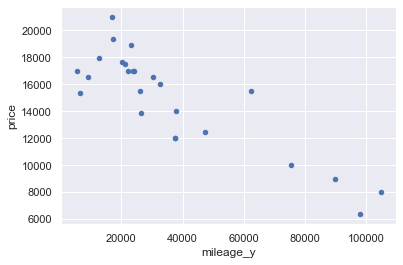

In [21]:
import seaborn as sns
sns.set()

# negative relationship between mileage and price
df_all.merge(X, left_index=True, right_index=True).plot(x='mileage_y', y='price', kind='scatter')